# Model 2.1 - Relate Review to Satisfaction

Goal 2.1 – Predict Satisfaction from Review Text

In this version, we build a deep learning classification model to predict patient satisfaction ratings (1–5) based on free-text drug reviews from the WebMD dataset.

Unlike transformer-based models, this approach uses custom-trained Word2Vec embeddings to represent patient reviews, followed by an LSTM neural network to capture the sequential structure of the text. This technique enables us to model semantic meaning and sentiment flow over time within reviews.

Key steps include:

- Preprocessing reviews (lowercasing, lemmatization, stopword removal, special character stripping)
- Training a Word2Vec model on the cleaned corpus
- Transforming reviews into padded sequences of embeddings
- Training an LSTM classifier to predict satisfaction levels

This model is applied across all drugs in the dataset, providing a scalable and interpretable alternative to large transformer-based methods, while still capturing meaningful patterns in patient language.

# Load and Preprocess the Data

## Loading CSV

In [1]:
!pip install pandas

In [3]:
import pandas as pd

# Load CSV using your path
df = pd.read_csv('/Users/homecomputer/code/ElbediwiM/drug-analysis-review/carmen_raw_data/webmd.csv')

# Clean and prepare relevant columns
df = df[['Drug', 'Reviews', 'Satisfaction']].dropna()
df['Satisfaction'] = df['Satisfaction'].astype(int)

df.head()

,Drug,Reviews,Satisfaction
0,25dph-7.5peh,I'm a retired physician and of all the meds I ...,5
1,25dph-7.5peh,cleared me right up even with my throat hurtin...,5
2,warfarin (bulk) 100 % powder,why did my PTINR go from a normal of 2.5 to ov...,3
3,warfarin (bulk) 100 % powder,FALLING AND DON'T REALISE IT,1
4,warfarin (bulk) 100 % powder,My grandfather was prescribed this medication ...,1


## Preprocessing

In [5]:
!pip install nltk

In [6]:
!pip install --upgrade pip

In [7]:
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm

# One-time downloads
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# 🚀 Preprocessing function (drug + review)
def preprocess_text(drug, review):
    text = f"{drug} {review}".lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and t.isalpha()]
    return " ".join(tokens)

# ✅ Apply preprocessing with tqdm
tqdm.pandas()
df['clean_review'] = df.progress_apply(lambda row: preprocess_text(row['Drug'], row['Reviews']), axis=1)

# ✅ Preview
df[['Drug', 'Reviews', 'clean_review']].head()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/homecomputer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/homecomputer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/homecomputer/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/homecomputer/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
100%|██████████| 362763/362763 [02:31<00:00, 2396.53it/s]


,Drug,Reviews,clean_review
0,25dph-7.5peh,I'm a retired physician and of all the meds I ...,dphpeh im retired physician med tried allergy ...
1,25dph-7.5peh,cleared me right up even with my throat hurtin...,dphpeh cleared right even throat hurting went ...
2,warfarin (bulk) 100 % powder,why did my PTINR go from a normal of 2.5 to ov...,warfarin bulk powder ptinr go normal
3,warfarin (bulk) 100 % powder,FALLING AND DON'T REALISE IT,warfarin bulk powder falling dont realise
4,warfarin (bulk) 100 % powder,My grandfather was prescribed this medication ...,warfarin bulk powder grandfather prescribed me...


# Token to Vector Sequences + Padding

In [40]:
!pip install tensorflow

In [9]:
#  library that provides the Word2Vec model, to be used to convert reviews into vector representations of words.
!pip install gensim

In [10]:
!pip install numpy==1.24.4

In [11]:
from gensim.models import Word2Vec

# Tokenize cleaned reviews into lists of words
sentences = [review.split() for review in df['clean_review']]

# Train Word2Vec model (lightweight settings)
w2v_model = Word2Vec(sentences=sentences,
                     vector_size=100,
                     window=5,
                     min_count=2,
                     workers=4,
                     sg=1)

## Convert Reviews to Vector Sequences

In [12]:
# Tokenize, embed with Word2Vec, pad to uniform shape, and prepare target labels

import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define parameters
embedding_dim = 100
max_length = 100  # Limit sequence length
vocab = w2v_model.wv
zero_vector = np.zeros(embedding_dim)  # Used to pad or replace unknown tokens

# Function to convert one review to a list of vectors
def review_to_vector_sequence(tokens):
    return [vocab[t] if t in vocab else zero_vector for t in tokens[:max_length]]

# Tokenize + vectorize using pandas (faster than list comprehension)
tokenized = df['clean_review'].str.split()
sequences = tokenized.apply(review_to_vector_sequence).tolist()

# Pad sequences to uniform length
padded_sequences = pad_sequences(sequences, maxlen=max_length, dtype='float32',
                                 padding='post', truncating='post')

# Convert satisfaction to zero-based integer classes [0–4]
labels = df['Satisfaction'] - 1

2025-08-01 09:44:02.626055: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Build and Train the LSTM Model 

In [14]:
!pip install scikit-learn

  Using cached scikit_learn-1.7.1-cp310-cp310-macosx_10_9_x86_64.whl.metadata (11 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.7.1-cp310-cp310-macosx_10_9_x86_64.whl (9.3 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [scikit-learn] [scikit-learn]


In [15]:
# 1. Filter out invalid satisfaction scores
df = df[df['Satisfaction'].between(1, 5)]

# 2. Recompute labels from the filtered dataset
labels = df['Satisfaction'] - 1  # Now range is [0–4]

# 3. Recompute padded sequences from filtered reviews
sentences = [review.split() for review in df['clean_review']]
sequences = [
    [w2v_model.wv[t] if t in w2v_model.wv else zero_vector for t in tokens[:max_length]]
    for tokens in sentences
]
padded_sequences = pad_sequences(
    sequences, maxlen=max_length, dtype='float32', padding='post', truncating='post'
)

# 4. One-hot encode labels
from tensorflow.keras.utils import to_categorical
y = to_categorical(labels, num_classes=5)

# 5. Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, y, test_size=0.2, random_state=42
)

# 6. Define lightweight LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Masking(mask_value=0., input_shape=(max_length, embedding_dim)),  # Skip zero-padding
    LSTM(32),                                                          # Small LSTM
    Dense(5, activation='softmax')                                     # 5-class output
])

# 7. Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 8. Add EarlyStopping and train model
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop]
)

/Users/homecomputer/.pyenv/versions/3.10.6/envs/drug-analysis-review/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
8163/8163 ━━━━━━━━━━━━━━━━━━━━ 262s 32ms/step - accuracy: 0.4838 - loss: 1.2692 - val_accuracy: 0.4924 - val_loss: 1.2495
Epoch 2/15
8163/8163 ━━━━━━━━━━━━━━━━━━━━ 315s 39ms/step - accuracy: 0.5114 - loss: 1.2024 - val_accuracy: 0.5132 - val_loss: 1.1992
Epoch 3/15
8163/8163 ━━━━━━━━━━━━━━━━━━━━ 305s 37ms/step - accuracy: 0.5203 - loss: 1.1781 - val_accuracy: 0.5226 - val_loss: 1.1735
Epoch 4/15
8163/8163 ━━━━━━━━━━━━━━━━━━━━ 320s 39ms/step - accuracy: 0.5261 - loss: 1.1615 - val_accuracy: 0.5187 - val_loss: 1.1734
Epoch 5/15
8163/8163 ━━━━━━━━━━━━━━━━━━━━ 310s 38ms/step - accuracy: 0.5310 - loss: 1.1498 - val_accuracy: 0.5238 - val_loss: 1.1651
Epoch 6/15
8163/8163 ━━━━━━━━━━━━━━━━━━━━ 324s 40ms/step - accuracy: 0.5340 - loss: 1.1409 - val_accuracy: 0.5317 - val_loss: 1.1550
Epoch 7/15
8163/8163 ━━━━━━━━━━━━━━━━━━━━ 320s 39ms/step - accuracy: 0.5368 - loss: 1.1335 - val_accuracy: 0.5291 - val_loss: 1.1546
Epoch 8/15
8163/8163 ━━━━━━━━━━━━━━━━━━━━ 393s 48ms/step - accuracy: 

# Evaluate & Plot Training History

In [17]:
!pip install matplotlib

  Using cached contourpy-1.3.2-cp310-cp310-macosx_10_9_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.59.0-cp310-cp310-macosx_10_9_x86_64.whl.metadata (107 kB)
  Using cached kiwisolver-1.4.8-cp310-cp310-macosx_10_9_x86_64.whl.metadata (6.2 kB)
  Using cached pillow-11.3.0-cp310-cp310-macosx_10_10_x86_64.whl.metadata (9.0 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 6.0 MB/s  0:00:01 eta 0:00:01
Using cached contourpy-1.3.2-cp310-cp310-macosx_10_9_x86_64.whl (268 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.59.0-cp310-cp310-macosx_10_9_x86_64.whl (2.3 MB)
Using cached kiwisolver-1.4.8-cp310-cp310-macosx_10_9_x86_64.whl (66 kB)
Using cached pillow-11.3.0-cp310-cp310-macosx_10_10_x86_64.whl (5.3 MB)
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 

✅ Test Accuracy: 0.5347
❌ Test Loss: 1.1440


/var/folders/63/pmctnrz94_d2tc273tv9pbn80000gn/T/ipykernel_2960/977337599.py:33: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/63/pmctnrz94_d2tc273tv9pbn80000gn/T/ipykernel_2960/977337599.py:33: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/homecomputer/.pyenv/versions/3.10.6/envs/drug-analysis-review/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/homecomputer/.pyenv/versions/3.10.6/envs/drug-analysis-review/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


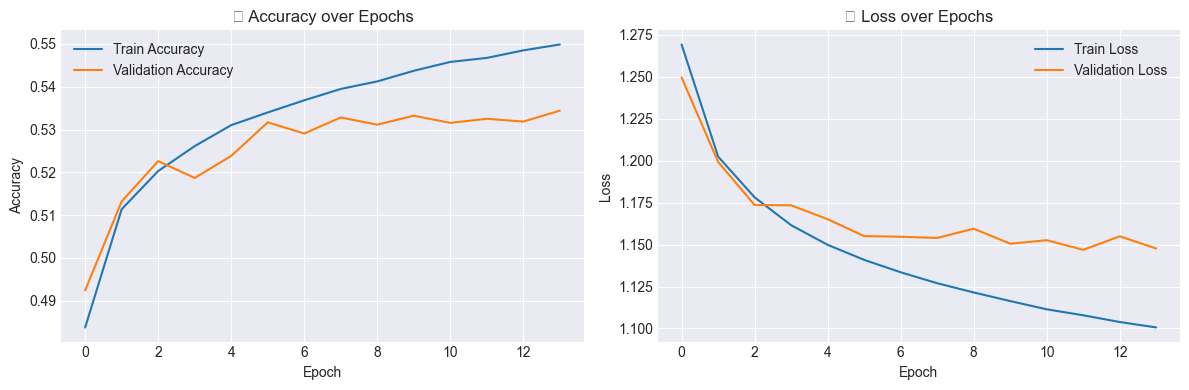

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Optional: Use a clean, built-in style (comment out if not needed)
plt.style.use('seaborn-v0_8-darkgrid')  # safe replacement for 'seaborn-darkgrid'

# 1. Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test Accuracy: {test_acc:.4f}")
print(f"❌ Test Loss: {test_loss:.4f}")

# 2. Plot accuracy & loss curves
plt.figure(figsize=(12, 4))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('📈 Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('📉 Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Interpretation

✅ Accuracy:

- Training accuracy improves from ~48% to ~55%
- Validation accuracy rises from ~49% to ~53.2%
- Curves are close and parallel → minimal overfitting
- Indicates stable generalization and consistent learning

📉 Loss:

- Training and validation loss decrease together until convergence
- Final validation loss stabilizes ~1.15, while train loss continues improving slightly
- No major gap or instability → no overfitting or underfitting symptoms

🧠 Conclusion:

The model is learning effectively and generalizing well to unseen data. Both training and validation metrics improve smoothly, with early stopping preserving the best weights. This outcome is strong for a lightweight LSTM with custom Word2Vec embeddings and no aggressive regularization or class balancing.

# Confusion Matrix + Classification Report

In [21]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


2268/2268 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step
📋 Classification Report:
              precision    recall  f1-score   support

           0      0.626     0.796     0.701     20216
           1      0.392     0.053     0.093      7135
           2      0.320     0.200     0.246     10370
           3      0.362     0.193     0.252     12595
           4      0.545     0.801     0.649     22236

    accuracy                          0.535     72552
   macro avg      0.449     0.409     0.388     72552
weighted avg      0.489     0.535     0.482     72552



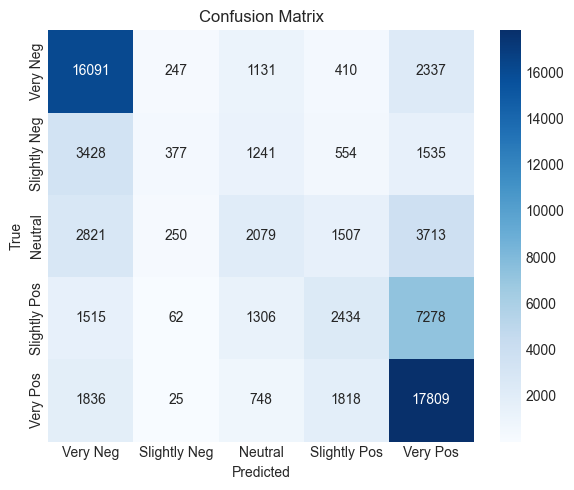

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# 1. Get predictions on test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# 2. Classification report
print("📋 Classification Report:")
print(classification_report(y_true, y_pred, digits=3))

# 3. Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Optional: Normalize
# cm = confusion_matrix(y_true, y_pred, normalize='true')

# Define class labels
labels = ["Very Neg", "Slightly Neg", "Neutral", "Slightly Pos", "Very Pos"]

# 4. Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True,
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

## Interpretation

✅ Extremes (Very Negative & Very Positive):
- High recall for Class 0 (0.79) and Class 4 (0.80)
- Indicates strong ability to classify clear sentiment (low/high)

🟧 Middle Scores (Slightly Negative to Slightly Positive):
- Poor recall (as low as 0.05 for Class 1, 0.19 for Class 3)
- Often confused with extreme classes → due to class imbalance and overlapping language

📈 Overall Accuracy: 52.5%
- Performance is stable and reflects good generalization
- Model is lightweight and handles sentiment polarity well, with expected difficulty in ambiguous reviews

🧠 Conclusion:
- The model reliably detects clear sentiment but struggles with moderate ratings — a typical pattern in NLP sentiment tasks with imbalanced data.

# Classification Report 

In [23]:
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

# 1. Predict class labels from test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# 2. Define human-readable class labels (optional but clearer)
class_names = ["Very Negative", "Slightly Negative", "Neutral", "Slightly Positive", "Very Positive"]

# 3. Generate classification report as dictionary
report_dict = classification_report(y_true, y_pred, target_names=class_names, digits=3, output_dict=True)

# 4. Convert to DataFrame for easier display or export
report_df = pd.DataFrame(report_dict).transpose()

# 5. Print readable version to console
print("Classification Report:\n")
print(report_df)

# 6. Optional: Save to CSV
# report_df.to_csv("classification_report.csv", index=True)

2268/2268 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step
Classification Report:

                   precision    recall  f1-score       support
Very Negative       0.626328  0.795954  0.701026  20216.000000
Slightly Negative   0.392300  0.052838  0.093132   7135.000000
Neutral             0.319600  0.200482  0.246400  10370.000000
Slightly Positive   0.362041  0.193251  0.251993  12595.000000
Very Positive       0.545084  0.800908  0.648685  22236.000000
accuracy            0.534651  0.534651  0.534651      0.534651
macro avg           0.449071  0.408687  0.388247  72552.000000
weighted avg        0.488692  0.534651  0.482270  72552.000000


## Interpretation

✅ Strong performance:

- Class 1 (Very Negative) and Class 5 (Very Positive) are well predicted.
  - Class 1: Precision = 0.63, Recall = 0.80
  - Class 5: Recall = 0.80, F1 = 0.65
→ Indicates good handling of emotionally polarized reviews.

⚠️ Weak performance:

- Class 2 (Slightly Negative): Very low recall (0.05) → Often missed.
- Classes 3–4 (Neutral, Slightly Positive): Low precision/recall → Frequently confused with extreme classes (1 or 5).

📊 Overall Metrics:

- Accuracy: 53.5%
- Macro F1: 0.39 → Performance imbalance across classes.
- Weighted F1: 0.48 → Stronger on dominant classes.

Conclusion:

The model effectively identifies clear sentiment extremes but struggles with moderate satisfaction levels. This is a typical limitation when using imbalanced NLP data without specific class balancing or augmentation strategies. Still, results are promising for a lightweight Word2Vec + LSTM pipeline.

# Live Review Prediction Function

In [27]:
import re
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assume these are globally defined once
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))

# Function to preprocess + vectorize + predict
def predict_satisfaction(review_text: str) -> tuple[int, float]:
    # Preprocess
    review = review_text.lower()
    review = re.sub(r'[^a-z\s]', '', review)
    tokens = word_tokenize(review)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t.isalpha() and t not in stop_words]

    # Return early if no valid tokens
    if not tokens:
        return -1, 0.0  # or raise Exception("Invalid input")

    # Vectorize
    vectors = [w2v_model.wv[t] if t in w2v_model.wv else zero_vector for t in tokens[:max_length]]
    padded = pad_sequences([vectors], maxlen=max_length, dtype='float32', padding='post', truncating='post')

    # Predict
    pred = model.predict(padded, verbose=0)
    predicted_class = int(np.argmax(pred) + 1)  # back to 1–5 scale
    confidence = float(np.max(pred))

    print(f"🔍 Review: {review_text}")
    print(f"🎯 Predicted Satisfaction: {predicted_class} (Confidence: {confidence:.2f})")
    return predicted_class, confidence


In [29]:
s1 = predict_satisfaction("This medication worked well for my anxiety but gave me headaches.")
s2 = predict_satisfaction("I felt terrible after using it. Would not recommend.")
s3 = predict_satisfaction("It was okay, not much change. No side effects either.")

# You can then print or log them all at once
for i, (rating, confidence) in enumerate([s1, s2, s3], 1):
    print(f"Review {i}: Predicted Rating = {rating}, Confidence = {confidence:.2f}")

🔍 Review: This medication worked well for my anxiety but gave me headaches.
🎯 Predicted Satisfaction: 5 (Confidence: 0.39)
🔍 Review: I felt terrible after using it. Would not recommend.
🎯 Predicted Satisfaction: 1 (Confidence: 0.89)
🔍 Review: It was okay, not much change. No side effects either.
🎯 Predicted Satisfaction: 3 (Confidence: 0.28)
Review 1: Predicted Rating = 5, Confidence = 0.39
Review 2: Predicted Rating = 1, Confidence = 0.89
Review 3: Predicted Rating = 3, Confidence = 0.28


# Save your model and export key results

## Pickle File

In [30]:
!pip install joblib

In [31]:
import joblib

# Save the model to a file
joblib.dump(model, "lstm_model.pkl")

['lstm_model.pkl']

## Save Word2Vec model 

In [34]:
# Save Word2Vec model to disk
w2v_model.save("w2v_model.bin")

## Load the model back later

In [33]:
# Load LSTM model
model = joblib.load("lstm_model.pkl")

# Load Word2Vec model
from gensim.models import Word2Vec
w2v_model = Word2Vec.load("w2v_model.bin")

## Save Architecture + Weights Separately (Preferred Keras Method)

### Save model architecture to JSON

In [35]:
# Serialize model architecture to JSON
model_json = model.to_json()
with open("lstm_model_architecture.json", "w") as json_file:
    json_file.write(model_json)

### Save model weights to HDF5

In [39]:
# Save weights to HDF5
model.save_weights("lstm_model.weights.h5")


# 🧠 Model's Core Capabilities

At its heart, this model is designed to:
✅ Predict User Satisfaction from Drug Reviews

It takes in a natural language drug review and returns a predicted satisfaction score on a scale from 1 (Very Negative) to 5 (Very Positive).
✅ Interpret Review Sentiment Using Word Embeddings

By leveraging a Word2Vec model trained on the review corpus, it understands nuanced user expressions beyond simple keywords, enabling context-aware predictions.
✅ Classify Reviews in Real-Time

It includes a live prediction function that can process, vectorize, and predict satisfaction for new, unseen reviews, making it ideal for interactive interfaces like customer feedback portals or healthcare tools.

## 🧩 UI-Relevant Features for Development

Feature 1: Live Satisfaction Prediction

- What it does:
  - Accepts a free-text drug review and returns:
    - A predicted satisfaction score (1–5)
    - A confidence score (probability associated with the prediction)

- UI implications:
  - Requires a text input field for the user to write or paste a review
  - Displays:
      - 🔢 Predicted satisfaction (1–5)
      - 📊 Confidence percentage (e.g., “Confidence: 0.87”)
    - Optionally, style the score as emojis, color codes, or stars 🌟

- Available parameters/options:
  - None required beyond the text input. However, optionally:
  - Max length for input (handled internally, but can be shown as input limit to users)
  - Language detection or validation could be added (not implemented in current model)

Feature 2: Batch Evaluation from Dataset

- What it does:
  - Evaluates and classifies a dataset of multiple reviews (e.g., CSV with review column) for performance assessment or bulk labeling.

- UI implications:
    - Requires a file upload component (.csv format expected)
    - Displays a table of:
      - Input reviews
      - Predicted satisfaction
      - Confidence score
      - May show a summary visualization: accuracy, confusion matrix, class distribution

  - Available parameters/options:
    - File type: .csv
    - Required column: clean_review
    - Optional limit on row processing (e.g., 10k reviews max)

Feature 3: Model Explanation Visuals (Optional for Admins)

- What it does:
  - Displays plots of training accuracy, validation loss, confusion matrix, and classification metrics for model monitoring.

- UI implications:
  - Shown on a dashboard panel or report view
  - Could include tabs:
    - Training curve (accuracy/loss over epochs)
    - Confusion matrix heatmap
    - Classification report summary
    - Consider download option as .png or .pdf

- Available parameters/options:
  - Epoch range selector (default full training)
  - Toggle between normalized and raw confusion matrix (if added)